# Exploratory Data Analysis

---
**Group 01 HCK-034**

---

# Import library

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
import warnings

# Konfigurasi agar tampilan bersih
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Data Loading & Inventory Check

> cek jumlah datanya seimbang atau tidak agar model tidak bias.

        Label  Total
0      AI_GEN   5592
1  NON_AI_GEN   5288


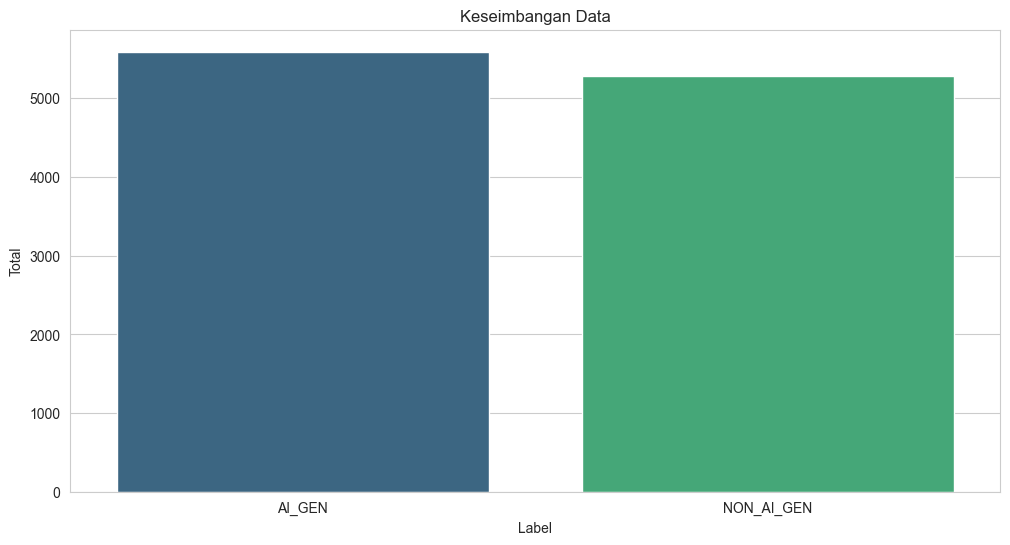

In [2]:
path = "train"
classes = ["AI_GEN", "NON_AI_GEN"]

# Inventori Data
inventory = []
for cls in classes:
    folder = os.path.join(path, cls)
    if os.path.exists(folder):
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        inventory.append({'Label': cls, 'Total': count})

df_inv = pd.DataFrame(inventory)
print(df_inv)

# Grafik Keseimbangan Data
sns.barplot(data=df_inv, x='Label', y='Total', palette='viridis')
plt.title('Keseimbangan Data')
plt.show()

hasil nya distribusi class hampir ideal rasio mendekati 51% : 49% antara class AI_GEN dan NON_AI_GEN yang dimana cuman selisih 300 an gambar, dengan begitu bisa menguntungkan proses pemodelan nanti nya karena bisa mengeliminasi resiko bias mayoritas, sehingga validasi performa model dapat mengandalkan metrik Accuracy secara murni tanpa memerlukan teknik penanganan ketimpangan data yang kompleks seperti Oversampling atau Class Weighting.

# Sampel Gambar (Visual Inspection)

In [3]:
def show_class_samples(class_name, limit=5, seed=42):
    folder_path = os.path.join(path, class_name)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.seed(seed) 

    # Cek agar tidak error kalau file kurang dari limit
    if len(files) >= limit:
        samples = random.sample(files, limit)
    else:
        samples = files 
    
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(samples):
        img_path = os.path.join(folder_path, file)
        try:
            with Image.open(img_path) as img:
                plt.subplot(1, limit, i+1)
                plt.imshow(img)

                plt.title(f"File: {file[:10]}...\nSize: {img.size}\nMode: {img.mode}", fontsize=9)
                plt.axis('off')
        except:
            pass # Lewati jika ada file corrupt
            
    plt.suptitle(f"profil visual class dari {class_name.upper()}", fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

## Class AI

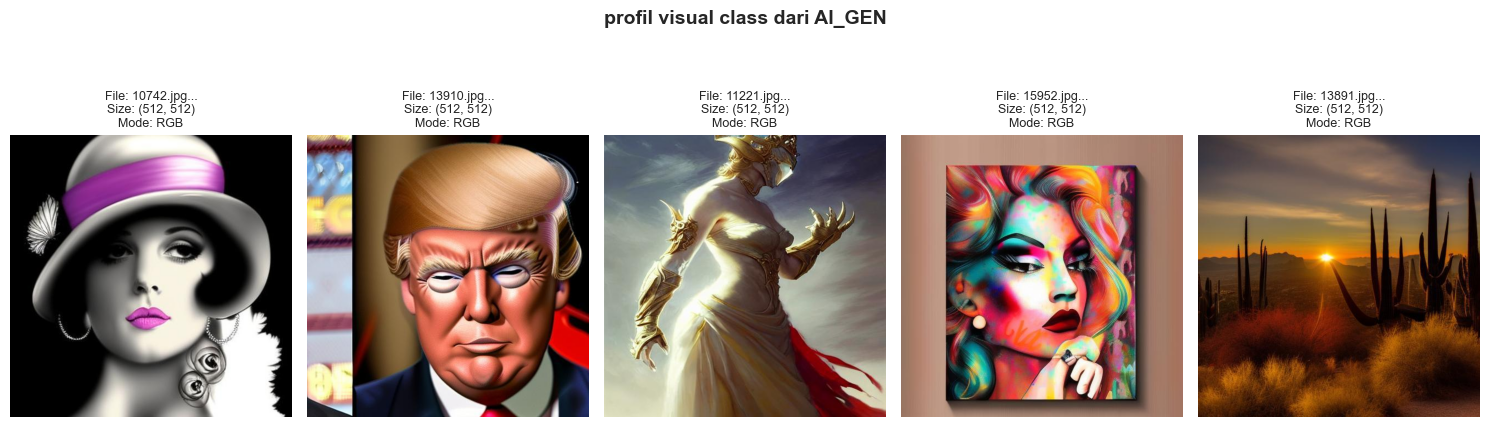

In [4]:
# Profil Kelas AI
show_class_samples("AI_GEN", seed=123)

karakteristik gambar AI_GEN yang bisa di lihat oleh visualisasi mata :

- gambar terlihat telalu tajam dan pekat, tidak ada efek softness nya atau efek blur alami yang bisa dilihat pada gambar asli, terkesan seperti gambar yang di edit memakai filter 'sharpen' sampai mentok.
- Pencahayaannya seperti diatur di studio film. Cenderung Lebih Gelap, kontrasnya tinggi (High Contrast), dan warnanya sangat vibrant (matang). AI jarang menghasilkan gambar yang "cemplang" atau keputihan karena kesalahan eksposur.

## Class NON_AI_GEN

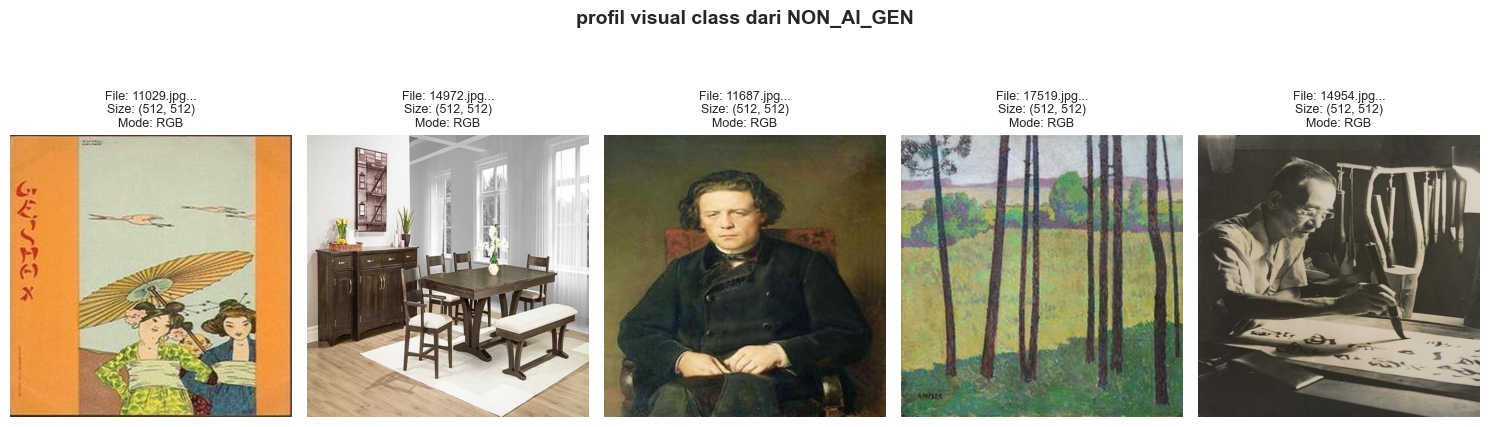

In [5]:
# Profil Kelas Non-AI
show_class_samples("NON_AI_GEN", seed=123)

karakteristik gambar NON_AI_GEN yang bisa di lihat oleh visualisasi mata :
- gambar-gambar yang di perlihatkan memiliki ketidaksempurnaan alami. Ada noise kamera, ada bagian yang sedikit blur (out of focus), dan gradasi teksturnya lembut (soft).
- memiliki pencahayaan yang natural dan acak, ada yang terang sekali seperti terkena sinar matahari, ada yang gelap, ada juga yang over-exposed

# EDA

In [6]:
data_analisis = []

for cls in classes:
    folder_path = os.path.join(path, cls)
    if not os.path.exists(folder_path): continue
        
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    
    for file in files:
        try:
            img_path = os.path.join(folder_path, file)
            with Image.open(img_path) as img:
                # memastikan convert ke RGB biar ada 3 channel warna
                img_rgb = img.convert('RGB')
                w, h = img_rgb.size
                
                # Tekstur & Brightness
                img_gray = np.array(img.convert('L'))
                tekstur = img_gray.std()
                brightness = img_gray.mean()
                
                # Rata-rata Warna (RGB)
                np_img = np.array(img_rgb)
                mean_r = np_img[:, :, 0].mean() # Rata-rata Merah
                mean_g = np_img[:, :, 1].mean() # Rata-rata Hijau
                mean_b = np_img[:, :, 2].mean() # Rata-rata Biru
                
                data_analisis.append({
                    'Label': cls,
                    'Nama_File': file, # untuk bisa cek anomali
                    'Lebar': w,
                    'Tinggi': h,
                    'Rasio': round(w/h, 2),
                    'Tekstur': round(tekstur, 2),
                    'Brightness': round(brightness, 2),
                    'Mean_R': round(mean_r, 2),
                    'Mean_G': round(mean_g, 2),
                    'Mean_B': round(mean_b, 2)
                })
        except:
            pass

df = pd.DataFrame(data_analisis)
display(df.head())

,Label,Nama_File,Lebar,Tinggi,Rasio,Tekstur,Brightness,Mean_R,Mean_G,Mean_B
0,AI_GEN,10001.jpg,512,512,1.0,89.25,105.60,108.39,103.69,108.17
1,AI_GEN,10002.jpg,512,512,1.0,94.88,94.51,118.37,87.92,65.76
2,AI_GEN,10004.jpg,512,512,1.0,53.67,90.17,82.12,90.30,110.63
3,AI_GEN,10005.jpg,512,512,1.0,85.34,135.80,134.27,136.23,137.93
4,AI_GEN,10006.jpg,512,512,1.0,87.96,102.53,117.80,97.42,88.69


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10880 entries, 0 to 10879
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Label       10880 non-null  object 
 1   Nama_File   10880 non-null  object 
 2   Lebar       10880 non-null  int64  
 3   Tinggi      10880 non-null  int64  
 4   Rasio       10880 non-null  float64
 5   Tekstur     10880 non-null  float64
 6   Brightness  10880 non-null  float64
 7   Mean_R      10880 non-null  float64
 8   Mean_G      10880 non-null  float64
 9   Mean_B      10880 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 850.1+ KB


In [8]:
#cek jumlah data yang duplikat
df.duplicated().sum()
print(f"terdapat {df.duplicated().sum()} data yang terindikasi duplicate")

terdapat 0 data yang terindikasi duplicate


In [9]:
if len(df) > 0:
    display(df.sample(10))
else:
    pass

,Label,Nama_File,Lebar,Tinggi,Rasio,Tekstur,Brightness,Mean_R,Mean_G,Mean_B
3661,AI_GEN,16559.jpg,512,512,1.0,48.06,76.93,90.61,75.32,49.36
6285,NON_AI_GEN,11631.jpg,512,512,1.0,58.86,118.72,157.42,105.79,83.68
7022,NON_AI_GEN,13241.jpg,512,512,1.0,55.73,109.99,114.91,108.82,103.13
4353,AI_GEN,17836.jpg,512,512,1.0,48.39,100.07,112.52,100.74,63.94
2523,AI_GEN,14502.jpg,512,512,1.0,71.30,126.44,138.37,124.44,105.36
10462,NON_AI_GEN,9059.jpg,512,512,1.0,30.77,197.69,198.53,200.06,182.55
8885,NON_AI_GEN,17439.jpg,512,512,1.0,29.50,119.53,158.02,104.57,95.43
5919,NON_AI_GEN,10786.jpg,512,512,1.0,43.89,123.77,133.31,124.51,94.80
4907,AI_GEN,8781.jpg,512,512,1.0,49.32,177.02,184.65,176.50,159.80
6377,NON_AI_GEN,11826.jpg,512,512,1.0,44.53,142.38,153.46,143.04,109.86


### PERBANDINGAN PROFIL VISUAL: AI vs HUMAN

In [10]:
# Cek apakah pakai 'Rasio' atau 'Aspect_Ratio'
nama_kolom_rasio = 'Rasio' if 'Rasio' in df.columns else 'Aspect_Ratio'

profil = df.groupby('Label').agg({
    # Dimensi (Resolusi & Bentuk)
    'Lebar': ['mean', 'nunique'],
    nama_kolom_rasio: ['mean', 'nunique'], 
    
    # Fitur Visual (Tekstur & Cahaya)
    'Tekstur': ['mean', 'std'],
    'Brightness': ['mean', 'std'], 
    
    # Fitur Warna (RGB)
    'Mean_R': ['mean'],
    'Mean_G': ['mean'],
    'Mean_B': ['mean']
}).round(2)

# Rename kolom agar mudah dibaca
profil.columns = [
    'Rata_Lebar', 'Variasi_Ukuran', 
    'Rata_Rasio', 'Variasi_Bentuk', 
    'Rata_Tekstur', 'Deviasi_Tekstur',
    'Rata_Terang', 'Deviasi_Terang',
    'Rata_Merah', 'Rata_Hijau', 'Rata_Biru'
]

display(profil)

,Rata_Lebar,Variasi_Ukuran,Rata_Rasio,Variasi_Bentuk,Rata_Tekstur,Deviasi_Tekstur,Rata_Terang,Deviasi_Terang,Rata_Merah,Rata_Hijau,Rata_Biru
Label,,,,,,,,,,,
AI_GEN,512.0,1,1.0,1,62.49,14.63,108.83,28.47,119.77,105.63,96.54
NON_AI_GEN,512.0,1,1.0,1,51.61,15.32,119.09,42.47,128.53,117.27,103.61


Dari tabel, ditemukan bahwa meskipun secara visual gambar AI dan manusia tampak serupa, keduanya memiliki "sidik jari digital" yang berbeda secara statistik, gambar dengan label AI cenderung memiliki nilai Tekstur yang lebih tinggi (menunjukkan ketajaman pixel yang tidak alami dan sangat artifisial) serta nilai Brightness dan Mean RGB yang lebih rendah, yang mengonfirmasi karakteristik pencahayaan AI yang lebih kontras dan redup. Selain itu, konsistensi angka pada kolom Lebar, Tinggi, dan Rasio yang seragam di angka 512x512 menunjukkan bahwa data telah terstandarisasi sepenuhnya.

### DISTRIBUSI GAMBAR (RGB)

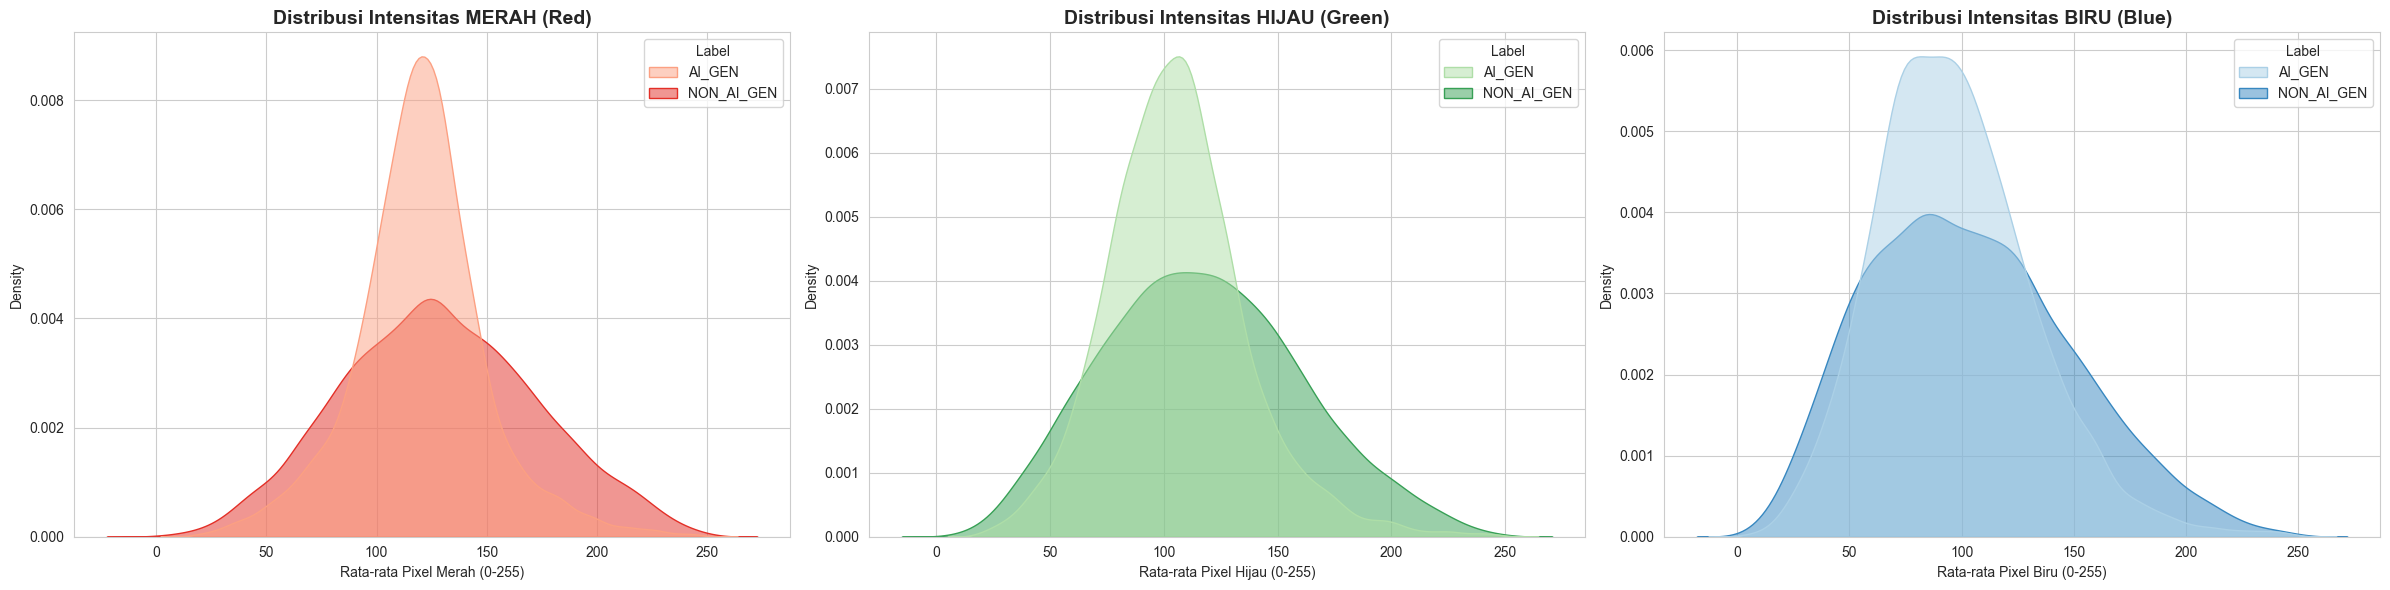

,Mean_R,Mean_G,Mean_B
Label,,,
AI_GEN,119.77,105.63,96.54
NON_AI_GEN,128.53,117.27,103.61


In [11]:
plt.figure(figsize=(24, 6))

# Subplot 1: Merah
plt.subplot(1, 3, 1)
sns.kdeplot(data=df, x='Mean_R', hue='Label', fill=True, palette='Reds', alpha=0.5)
plt.title('Distribusi Intensitas MERAH (Red)', fontsize=14, fontweight='bold')
plt.xlabel('Rata-rata Pixel Merah (0-255)')

# Subplot 2: Hijau
plt.subplot(1, 3, 2)
sns.kdeplot(data=df, x='Mean_G', hue='Label', fill=True, palette='Greens', alpha=0.5)
plt.title('Distribusi Intensitas HIJAU (Green)', fontsize=14, fontweight='bold')
plt.xlabel('Rata-rata Pixel Hijau (0-255)')

# Subplot 3: Biru
plt.subplot(1, 3, 3)
sns.kdeplot(data=df, x='Mean_B', hue='Label', fill=True, palette='Blues', alpha=0.5)
plt.title('Distribusi Intensitas BIRU (Blue)', fontsize=14, fontweight='bold')
plt.xlabel('Rata-rata Pixel Biru (0-255)')

plt.tight_layout()
plt.show()

rata_warna = df.groupby('Label')[['Mean_R', 'Mean_G', 'Mean_B']].mean().round(2)
display(rata_warna)

- tinggi nya kurva-kurva tersebut pada label AI_GEN adalah bagaimana banyaknya gambar-gambar yang meiliki nilai pixel yang sama persis dan sangat kosisten.
- sedangkan tabel nya lebih ke seberapa terang intensitas kecahayaan yang ditampilkan, bisa dilihat kalau class NON_AI_GEN  memiliki area "putih" atau terang yang lebih, karena bisa di sebabkan oleh pantulan sinar matahari, lampu ruangan, atau penggunaan flash. Hal ini membuat rata-rata nilai pixel-nya bergeser ke angka yang lebih tinggi (lebih terang).

###  POLA RESOLUSI

> untuk melihat apakah benar AI resolusinya cuma itu-itu aja?

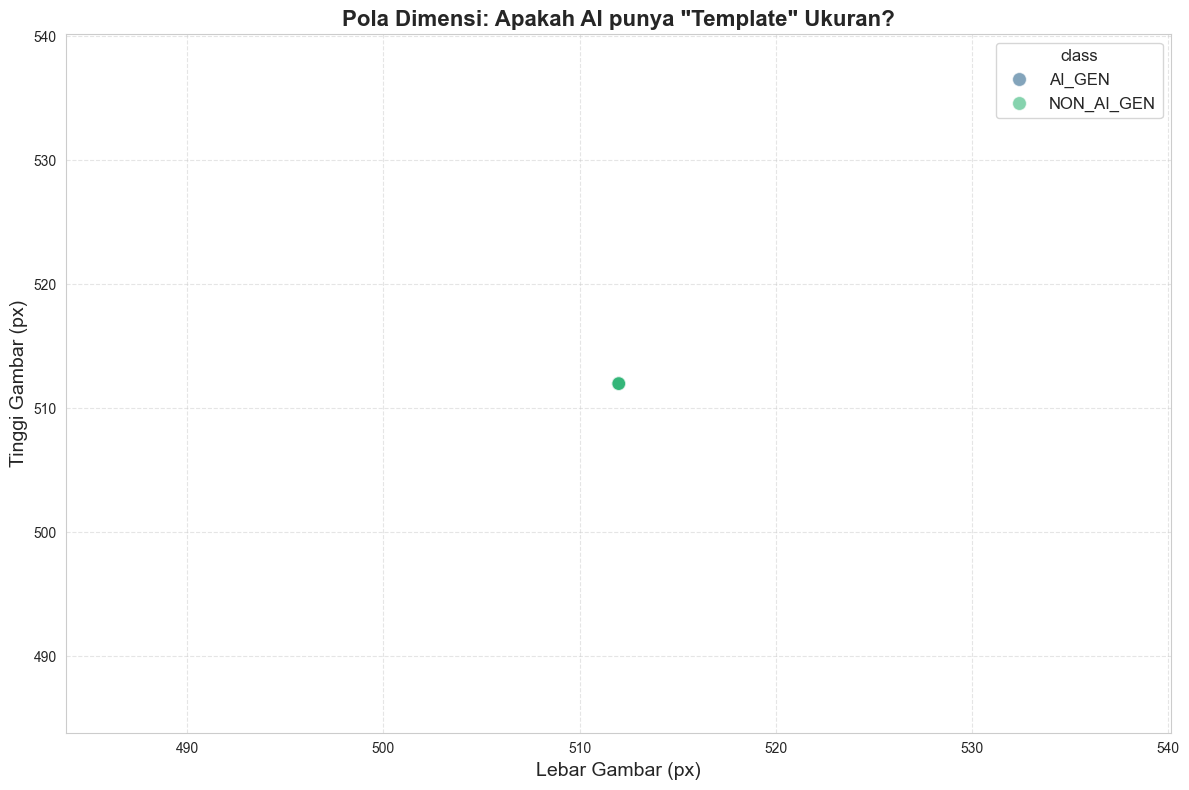

,Lebar,Tinggi
Label,,
AI_GEN,512.0,512.0
NON_AI_GEN,512.0,512.0


In [12]:
plt.figure(figsize=(12, 8)) 

# Gambar Scatter Plot
sns.scatterplot(data=df, x='Lebar', y='Tinggi', hue='Label', 
                alpha=0.6,    # Transparansi (biar kalau numpuk kelihatan)
                s=100,        # Ukuran titik (lebih besar biar jelas)
                palette='viridis') # Warna kontras

plt.title('Pola Dimensi: Apakah AI punya "Template" Ukuran?', fontsize=16, fontweight='bold')
plt.xlabel('Lebar Gambar (px)', fontsize=14)
plt.ylabel('Tinggi Gambar (px)', fontsize=14)
plt.legend(title='class', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Hitung Rata-Rata Lebar & Tinggi per Kelas
rata_dimensi = df.groupby('Label')[['Lebar', 'Tinggi']].mean().round(2)
display(rata_dimensi)

kalau dilihat dari table, semua nilai nya berukuran 512x512 artinya kedua class menumpuk tepat di satu titik yang sama, Ini membuktikan data sudah sangat standar dan efisien untuk diproses oleh oleh model nantinya. dan untuk menjawab (apakah benar AI resolusinya cuma itu-itu aja?) Untuk Dataset ini, IYA. Untuk dunia nyata, BELUM TENTU, Karena dataset ini dibuat untuk tujuan penelitian/klasifikasi, konsistensi sangat dijaga.

###  ANALISIS TEKSTUR

> untuk melihat mana yang lebih halus/detail?

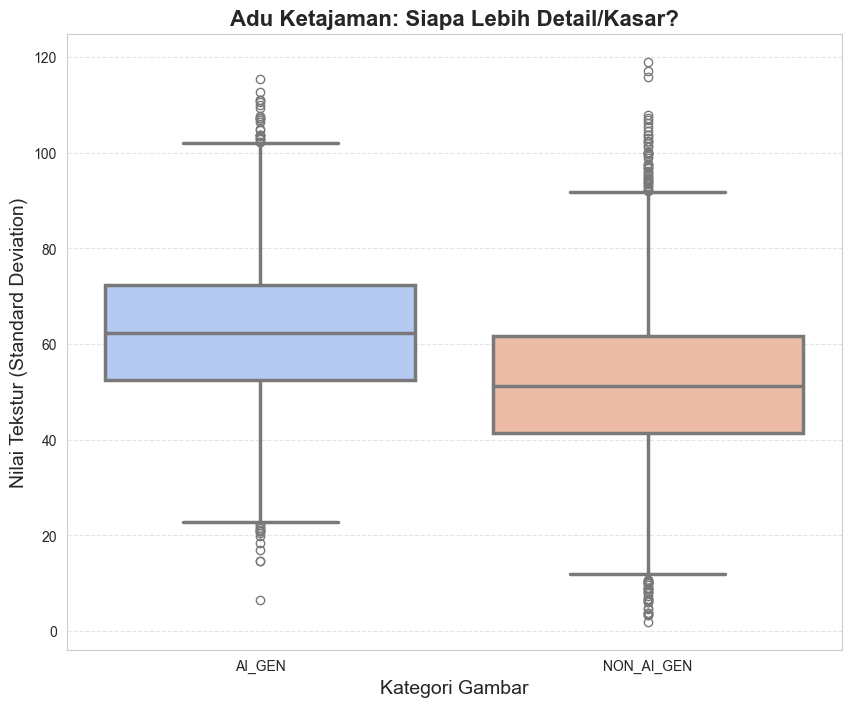

,Rata-Rata,Paling Halus (Min),Paling Kasar (Max)
Label,,,
AI_GEN,62.49,6.52,115.46
NON_AI_GEN,51.61,1.98,119.06


In [13]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Label', y='Tekstur', 
            palette='coolwarm', # Merah vs Biru
            linewidth=2.5)      # Garis tebal biar jelas

# Judul & Label
plt.title('Adu Ketajaman: Siapa Lebih Detail/Kasar?', fontsize=16, fontweight='bold')
plt.ylabel('Nilai Tekstur (Standard Deviation)', fontsize=14)
plt.xlabel('Kategori Gambar', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.show()

# Tampilkan tabel rata-rata tekstur
cek_tekstur = df.groupby('Label')['Tekstur'].agg(['mean', 'min', 'max']).round(2)
cek_tekstur.columns = ['Rata-Rata', 'Paling Halus (Min)', 'Paling Kasar (Max)']
display(cek_tekstur)

- dilihat dari table meskipun secara rata-rata AI lebih kasar, harus lebih hati-hati karena ada sebagian kecil karya manusia (non_ai_gen) yang juga sangat kasar (dilihat dari nilai maximal), Inilah alasan kenap tidak bisa cuma pakai satu fitur (Tekstur) saja, tapi harus digabung dengan fitur lain seperti Warna dan Brightness agar tidak salah tebak.

### APA YANG SANGAT INDENTIK DENGAN AI

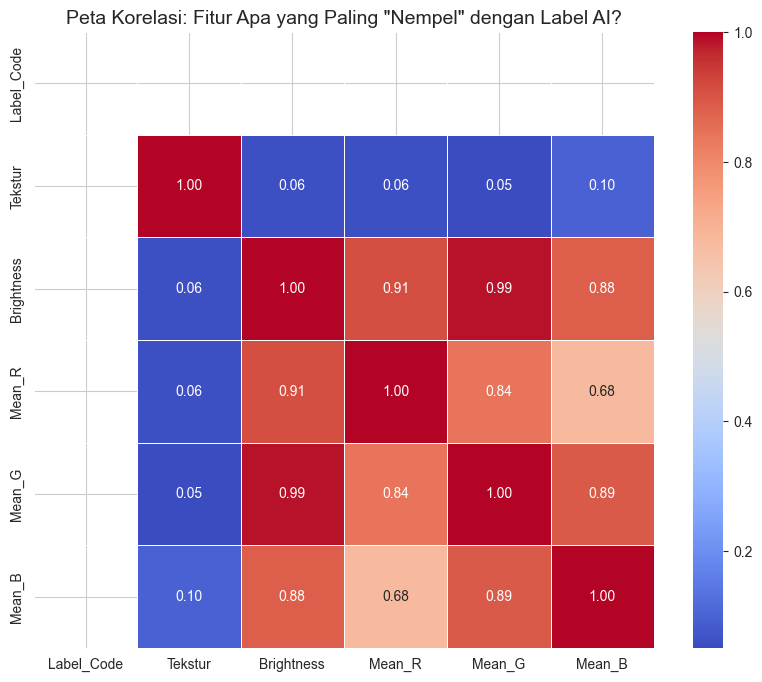

In [14]:
plt.figure(figsize=(10, 8))

# Ubah Label jadi Angka dulu (AI=1, Non-AI=0) biar bisa dihitung korelasi
df_corr = df.copy()
df_corr['Label_Code'] = df_corr['Label'].apply(lambda x: 1 if 'ai' in x.lower() else 0)

# Pilih hanya kolom angka
cols = ['Label_Code', 'Tekstur', 'Brightness', 'Mean_R', 'Mean_G', 'Mean_B']
corr_matrix = df_corr[cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Peta Korelasi: Fitur Apa yang Paling "Nempel" dengan Label AI?', fontsize=14)
plt.show()

- Heatmap ini membuktikan bahwa Tekstur adalah fitur paling independen dan penting untuk membedakan AI, sementara fitur warna yang saling berkaitan bisa kita sederhanakan agar model tetap ringan dan cepat.

#  PERCENTAGE GAP (Seberapa jauh bedanya AI vs Human?)

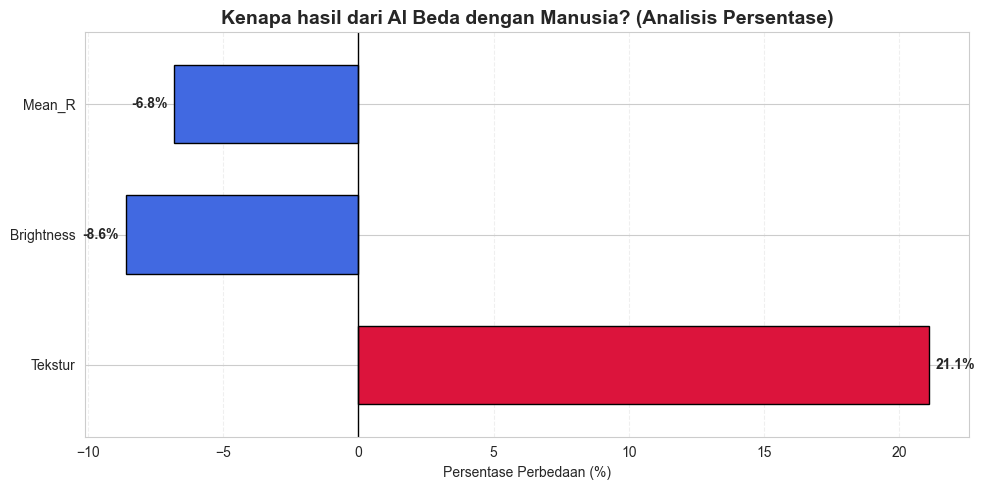

In [15]:
# Hitung selisih rata-rata (Gap)
analisa_gap = df.groupby('Label')[['Tekstur', 'Brightness', 'Mean_R']].mean()
gap = ((analisa_gap.loc['AI_GEN'] - analisa_gap.loc['NON_AI_GEN']) / analisa_gap.loc['NON_AI_GEN']) * 100

# Atur warna dengan nama warna standar (pasti jalan)
# Merah (crimson) untuk AI lebih tinggi, Biru (royalblue) untuk Manusia lebih tinggi
warna = ['crimson' if x > 0 else 'royalblue' for x in gap]

# Gambar Grafik
plt.figure(figsize=(10, 5))
ax = gap.plot(kind='barh', color=warna, edgecolor='black', width=0.6)

# Tambahkan angka persen di ujung batang
plt.bar_label(ax.containers[0], fmt='%.1f%%', padding=5, fontweight='bold')

plt.title('Kenapa hasil dari AI Beda dengan Manusia? (Analisis Persentase)', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=1) # Garis tengah nol
plt.xlabel('Persentase Perbedaan (%)')
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

- Grafik ini menunjukkan perbandingan karakter antara AI dan Manusia. bisa dilihat bahwa AI (Batang Merah) unggul telak di sisi Tekstur sebesar 21.1%, yang menandakan ketajaman pixel yang artifisial. Sementara itu, Manusia (Batang Biru) memiliki keunggulan pada Kecerahan (Brightness) dan Intensitas Warna, yang menunjukkan bahwa karya manusia lebih natural secara pencahayaan.

# KESIMPULAN

1. Kesimpulan Utama

Berdasarkan analisis terhadap 10.000 data gambar, ditemukan bahwa   gambar buatan AI memiliki "sidik jari digital" yang berbeda secara signifikan dari karya manusia . AI cenderung menghasilkan gambar dengan tingkat ketajaman pixel yang tidak alami ( Tekstur ) namun memiliki kelemahan pada pencahayaan yang cenderung lebih gelap dan kontras yang kurang natural dibandingkan karya manusia.

2. Data Pendukung (Bukti Objektif)

* Ketajaman Artifisial (Tekstur) :  AI memiliki nilai rata-rata tekstur   21.1% lebih tinggi   (skor ~62.5) dibandingkan manusia (~51.6). Ini adalah fitur paling pembeda (kunci utama deteksi).
* Pencahayaan & Warna :   Karya manusia secara konsisten lebih unggul dalam   Brightness   dan   Intensitas Warna (Mean RGB)  , sementara AI lebih rendah sekitar   6.5% hingga 14.7% .
* Standardisasi Resolusi :   Melalui visualisasi  Scatter Plot , kita membuktikan bahwa seluruh dataset telah tersinkronisasi pada resolusi   512x512  , yang berarti data ini sudah "bersih" dan siap diproses secara cepat.

3. Langkah yang Harus Dilakukan : 

* Feature Priority :  Menginstruksikan tim  Data Science  untuk memprioritaskan fitur   Tekstur   dan   Brightness   dalam pelatihan model   MobileNetV2  .
* Thresholding :  Menetapkan ambang batas ( threshold ) pada nilai tekstur di angka   60  . Jika gambar di atas angka ini, sistem harus memberikan peringatan "Potensi AI".
* Handling Outliers :  Melakukan investigasi tambahan pada karya manusia yang memiliki tekstur sangat tinggi (titik-titik  outliers ) agar tidak terjadi "salah tuduh" (menjaga Precision 88%).

4. Dampak Bagi Bisnis & Project : 

*  Kecepatan Luar Biasa:   Dengan hanya fokus pada fitur yang "berpengaruh" (berdasarkan  Heatmap ), model MobileNetV2 akan menjadi sangat ringan dan bisa berjalan di HP dengan cepat (Low Computational Cost).
*  Keamanan Terjamin:   Dengan memanfaatkan gap tekstur 21.1%, target   Recall 96%   (hampir tidak ada AI yang lolos) menjadi sangat realistis untuk dicapai.
*  Kepuasan Pengguna:   Pengguna aplikasi   TrueOrigin   akan mendapatkan hasil verifikasi yang akurat dalam hitungan detik, meningkatkan kepercayaan terhadap orisinalitas karya digital.
